In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pickle

import gym
import pybullet_envs
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from IPython.display import clear_output, display

from stable_baselines.a2c.utils import ortho_init
from stable_baselines.common.policies import MlpPolicy, ActorCriticPolicy
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines.common import set_global_seeds
from stable_baselines import PPO2, GAIL
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.gail import generate_expert_traj, ExpertDataset

In [2]:
env_id = "HumanoidBulletEnv-v0"
expert_folder = "tmp/gym/humanoid_pybullet/behaviour_cloning/"
expert_path = expert_folder + "expert_model.pkl"
save_path = expert_folder + "expert_model_traj.npz" # for expert trajectory
save_path_2 = expert_folder + "expert_model_samp.npz" # for expert obs random sampling
log_dir = expert_folder + "log/"

# Behaviour Cloning
- Note: Behaviour cloning in a simple supervized manner works fine with discrete control. For a continuous control task, this will not work well due to the sensitivity in the task. In a humanoid-walking situation, a slight mismatch of the expert signal and the pretrained signal can cause the agent to go away from the optimal trajectories which the pretrained agent may not encounter before. Thus, a sampling of the full input range from the expert network is required to completely "copy" the network information over to the new network.

# Trajectory Extraction 

#### Extract Samples - Expert Trajectory only

In [3]:
if os.path.exists(save_path) is False:
    env = gym.make(env_id)
    env._max_episode_steps=100 # only extract trajectory at the beginning
    env = DummyVecEnv([lambda: env])
    model = PPO2.load(expert_path, env=env)
    generate_expert_traj(model, save_path=save_path, env=env, n_episodes=3000)
else:
    print('trajectory already exists. Extraction will not be performed')

trajectory already exists. Extraction will not be performed


In [4]:
dataset = ExpertDataset(expert_path=save_path, batch_size=512, train_fraction=0.9)

actions (294528, 17)
obs (294528, 44)
rewards (294528, 1)
episode_returns (3000,)
episode_starts (294528,)
Total trajectories: -1
Total transitions: 294528
Average returns: 86.87152222510178
Std for returns: 26.723277095651756


In [5]:
# # sample input & output
# dataset.init_dataloader(1)
# dataset.get_next_batch()

#### Extract Samples - Full input Range

In [6]:
if os.path.exists(save_path_2) is False:
    # obtain empirical observation limit
    env = DummyVecEnv([lambda: gym.make(env_id)])
    model = PPO2.load(expert_path, env=env)

    obs = env.reset()
    obs_shape = env.observation_space.shape
    act_shape = env.action_space.shape

    obs_max = np.zeros(obs_shape)
    obs_min = np.zeros(obs_shape)
    for i in range(10000):
        obs, _, _, _ = env.step([env.action_space.sample()]) # add [] to match with vectorized environment
        obs_max = np.maximum(obs, obs_max)
        obs_min = np.minimum(obs, obs_min)
        
    # Generate Sampling Data
    data_num = 300000
    obs_data = np.zeros([data_num, obs_shape[0]])
    act_data = np.zeros([data_num, act_shape[0]])

    for i in range(data_num):
        obs_tmp = np.random.uniform(obs_min,obs_max)
        obs_data[i,:] = obs_tmp
        act_data[i,:],_ = model.predict(obs_tmp)

    numpy_dict = {
            'actions': act_data,
            'obs': obs_data,
            'rewards': np.zeros([data_num,1]), # dummy data
            'episode_returns': np.zeros(1000), # dummy data
            'episode_starts': np.zeros(data_num)} # dummy data

    if save_path_2 is not None:
        np.savez(save_path_2, **numpy_dict)        
else:
    print('sample file already exists. Extraction will not be performed')

sample file already exists. Extraction will not be performed


In [7]:
dataset_2 = ExpertDataset(expert_path=save_path_2, batch_size=512, train_fraction=0.9)

actions (300000, 17)
obs (300000, 44)
rewards (300000, 1)
episode_returns (1000,)
episode_starts (300000,)
Total trajectories: -1
Total transitions: 300000
Average returns: 0.0
Std for returns: 0.0


# Pretraining

In [8]:
###### env_id = "RoboschoolHumanoid-v1"
env = gym.make(env_id)
env = DummyVecEnv([lambda: env])

#### Pretrain using Behaviour Cloning & GAIL

In [9]:
policy_kwargs = dict(act_fun=tf.nn.relu, net_arch=[dict(vf=[256,256,256], pi=[256,256,256,8])])
model = GAIL(MlpPolicy, env, dataset, verbose=1, policy_kwargs=policy_kwargs)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use keras.layers.flatten instead.


In [ ]:
model.pretrain(dataset, n_epochs=100) #behaviour cloning


Pretraining with Behavior Cloning...


In [ ]:
model.learn(total_timesteps=100000)

In [5]:
env_v = gym.make('HumanoidBulletEnv-v0', render=True)
obs = env_v.reset()
for i in range(500):
    actions, _states = model.predict(obs)
    obs, rewards, dones, info = env_v.step(actions)

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [13]:
model.save(expert_folder+"pretrained_model_GAIL")
del model

In [11]:
model = GAIL.load(expert_folder+"pretrained_model_GAIL")
GAIL_param = model.get_parameters()

with open(expert_folder+'pretrained_model_GAIL_param.pkl', 'wb') as fp:
    pickle.dump(GAIL_param, fp, protocol=pickle.HIGHEST_PROTOCOL)

del model

Loading a model without an environment, this model cannot be trained until it has a valid environment.


# Fine Tuning

In [3]:
os.makedirs(log_dir, exist_ok=True)

# Set up Wrapper
from gym import RewardWrapper

class ModifyReward(RewardWrapper):
    def __init__(self, env):
        super(ModifyReward, self).__init__(env)

    def reward(self, reward):
        return reward
    
##########################################################################################
# Set up multiprocessing
def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.
    
    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environment you wish to have in subprocesses 
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    
    def _init():
        env = ModifyReward(gym.make(env_id))
        log_sub_dir = log_dir + '/env_{}'.format(str(rank))
        os.makedirs(log_sub_dir, exist_ok=True)
        env = Monitor(env, log_sub_dir, allow_early_resets=True)
        env.seed(seed + rank)
        return env
    set_global_seeds(seed)
    return _init

##########################################################################################
# Set up callback
best_mean_reward, n_steps = -np.inf, 0

def extract_xy(log_dir):
    """
    extract the # time steps and avg reward
    :param x: (int) # of time steps
    :param y: (float) average rewards
    """
    num_folder = 0
    x = 0
    y = []
    for folder in os.listdir(log_dir):
        if 'env' in folder:
            x_tmp, y_tmp = ts2xy(load_results(log_dir+folder), 'timesteps')
            if len(x_tmp) > 0:
                y.extend(list(y_tmp[-10:]))
                if x_tmp[-1] > x:
                    x = x_tmp[-1]
    y = sum(y)/len(y) if len(y) > 0 else -np.inf 
    return x, y

def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    global n_steps, best_mean_reward
    # Print stats every 2 calls
    if (n_steps + 1) % 2 == 0:
        # Evaluate policy training performance
        x, y = extract_xy(log_dir)
        if x > 0:
            mean_reward = y
            clear_output(wait=True)
            # use display(f) if you encounter performance issues
            print(x, 'timesteps')
            print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}". \
                  format(best_mean_reward, mean_reward))
            
            # New best model, you could save the agent here
            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                # Example for saving best model
                print("Saving new best model")
                _locals['self'].save(log_dir + 'best_model.pkl')
    n_steps += 1
    return True

In [4]:
env_id = "HumanoidBulletEnv-v0"
num_cpu = 8  # Number of processes to use
# Create the vectorized environment

env = SubprocVecEnv([make_env(env_id, i) for i in range(num_cpu)], start_method = 'fork')

In [5]:
def learning_rate(frac):
    return 1.0e-4*(np.exp(6*(frac-1)))

# modified policy network: with bottleneck
policy_kwargs = dict(act_fun=tf.nn.relu, net_arch=[dict(vf=[256,256,256], pi=[256,256,256,8])])

model = PPO2(MlpPolicy, env, verbose=0, policy_kwargs=policy_kwargs, 
             noptepochs=15, n_steps=512, learning_rate=learning_rate)

In [6]:
# extract parameters from GAIL for PPO2
with open(expert_folder+'pretrained_model_GAIL_param.pkl', 'rb') as fp:
    GAIL_param = pickle.load(fp)

model_paramlist = model.get_parameter_list()
model_paramname = []
for i in range(len(model_paramlist)):
    model_paramname.append(model_paramlist[i].name)

GAIL_param_extracted = {key:value for key,value in GAIL_param.items() if key in model_paramname}

In [7]:
model.load_parameters(GAIL_param_extracted, exact_match=True)

#### Step 4: Fine Tune the agent

In [8]:
model.learn(total_timesteps=40000000, callback=callback)

# saves the agent as a .pkl file
model.save(log_dir+'latest_trained_model') 

4999158 timesteps
Best mean reward: 1247.74 - Last mean reward per episode: 1086.29


#### Step 5: Render the results

In [6]:
model.load_parameters(log_dir+'best_model', exact_match=True)

In [15]:
env_v = gym.make('HumanoidBulletEnv-v0', render=True)
obs = env_v.reset()
for i in range(2000):
    actions, _states = model.predict(obs)
    obs, rewards, dones, info = env_v.step(actions)
    env_v.render()

#### Step 6: Plot the results

In [11]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve', instances=1, same_plot=False):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    :instances: (int) the number of instances to average
    """
    x, y = ts2xy(load_results(log_folder+'/env_0'), 'timesteps')

    if instances > 1:
        for i in range(1,instances):
            _, y_tmp = ts2xy(load_results(log_folder+'/env_'+str(i)), 'timesteps')
            if len(y) > len(y_tmp):
                y = y[:len(y_tmp)] + y_tmp
            else:
                y = y + y_tmp[:len(y)]
        y = y/instances
    
    y = moving_average(y, window=50) # change window value to change level of smoothness
    # Truncate x
    x = x[len(x) - len(y):]
    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    if same_plot is False:
        plt.show()

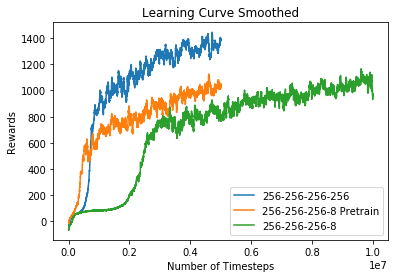

In [14]:
plot_results("tmp/gym/humanoid_pybullet/archive/RL 256-256-256-256", instances=8, same_plot=True)
plot_results(expert_folder+"archive/BC+GAIL+RL 256-256-256-8", instances=8, same_plot=True)
plot_results("tmp/gym/humanoid/archive/14-relu 256-256-256-8 80m step 1e-4 exp decayed lr", instances=8, same_plot=True)
# plt.xlim(0,2500000)
# plt.ylim(-100,1250)
plt.legend(['256-256-256-256','256-256-256-8 Pretrain','256-256-256-8'])